**Tabla de contenido**

- [Introducción](#Introducción)
- [Lib](#Lib)
- [Lectura de datos](#Lectura-de-datos)
- [Feature engineering](#Feature-engineering)
- [Escalado de datos](#Escalado-de-datos)
- [Entrenamiento y prueba](#Entrenamiento-y-prueba)
- [Feature importance](#Feature-importance)
    - [Shap](#Shap)
    - [RFE](#RFE)
- [Entrenamiento y test del modelo con datos importantes](#Entrenamiento-y-test-del-modelo-con-datos-importantes)
- [Cumplimiento de supuestos de la RL](#Cumplimiento-de-supuestos-de-la-RL)
    - [Residual Plot](#Residual-Plot)
    - [Breusch-Pagan test](#Breusch-Pagan-test)
    - [Durbin-Watson test](#Durbin-Watson-test)
    - [Q-Qplot](#Q-Qplot)
    - [Shapiro-Wilk test](#Shapiro-Wilk-test)
- [Resultados y conclusiones](#Resultados-y-conclusiones)

# Introducción

En este cuaderno nos enfocaremos en optimizar el modelo XGBRegressor. Actualmente, este modelo presenta limitaciones en cuanto al cumplimiento de los supuestos fundamentales para la inferencia estadística: homocedasticidad, normalidad de los errores y ausencia de multicolinealidad perfecta. Por lo tanto, trabajaremos en abordar y corregir estos problemas con el objetivo de mejorar la confiabilidad del modelo en el análisis y las predicciones.

# Lib

Para garantizar el correcto funcionamiento de este cuaderno, se requieren las siguientes librerías:

- **Python:** Versión 3.12.3
- **Pandas:** Versión 2.2.3
- **Matplotlib:** Versión 3.10.0
- **NumPy:** Versión 1.26.0
- **Seaborn:** Versión 0.13.2
- **Scikit-learn:** Versión 1.5.2
- **Shap:** Versión 0.46.0
- **Scipy:** Versión 1.14.1
- **XGBoost:** Versión 2.1.3
- **statsmodels:** Versión 0.14.4

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
import shap
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Lectura de datos

Los datos fueron leídos desde el archivo **WalmartSalesClean.csv**, que fue exportado desde el cuaderno LDV-APV y utiliza el carácter **","** como delimitador.

**Para leer correctamente este archivo, es necesario proporcionar la ruta donde se encuentra almacenado.**

In [2]:
os.chdir('D:\\6. NEXER\\master\\Solucion TFM\\2. Datos en CSV')
WalmartSales = pd.read_csv('WalmartSalesClean.csv', delimiter=',')
WalmartSales.head()

,Date,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Events
0,2010-02-12,1,164195744,1,38.51,2.548,211.242176,8.106,1
1,2010-02-19,1,161196816,0,39.93,2.514,211.289139,8.106,0
2,2010-02-26,1,140972752,0,46.63,2.561,211.319642,8.106,0
3,2010-03-05,1,155480672,0,46.50,2.625,211.350144,8.106,0
4,2010-03-12,1,143954160,0,57.79,2.667,211.380646,8.106,0


# Feature engineering

Vamos a descomponer la fecha en columnas predictoras. Esto involucra crear diferentes columnas, como son día, mes, año, día semana, trimestres y semanas del año.

In [3]:
WalmartSales['Date'] = pd.to_datetime(WalmartSales['Date'],format = '%Y-%m-%d')
WalmartSales['Day'] = WalmartSales['Date'].dt.day
WalmartSales['Weekday'] = WalmartSales['Date'].dt.weekday
WalmartSales['Month'] = WalmartSales['Date'].dt.month
WalmartSales['Year'] = WalmartSales['Date'].dt.year
WalmartSales['week'] = WalmartSales['Date'].dt.isocalendar().week
WalmartSales['quarter'] = WalmartSales['Date'].dt.quarter 
WalmartSales = WalmartSales.drop('Date', axis=1)
WalmartSales.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Events,Day,Weekday,Month,Year,week,quarter
0,1,164195744,1,38.51,2.548,211.242176,8.106,1,12,4,2,2010,6,1
1,1,161196816,0,39.93,2.514,211.289139,8.106,0,19,4,2,2010,7,1
2,1,140972752,0,46.63,2.561,211.319642,8.106,0,26,4,2,2010,8,1
3,1,155480672,0,46.50,2.625,211.350144,8.106,0,5,4,3,2010,9,1
4,1,143954160,0,57.79,2.667,211.380646,8.106,0,12,4,3,2010,10,1


# Escalado de datos

Utilizaremos el mismo escalador de datos empleado durante el entrenamiento de los modelos, **RobustScaler()**. Este escalador es una opción adecuada cuando los datos contienen valores atípicos o no siguen una distribución normal. Su principal ventaja es que hace que las variables continuas sean menos sensibles a los valores atípicos, aunque no necesariamente las ajusta a la misma escala que las características codificadas mediante técnicas como one-hot encoding.

In [4]:
def normalizar_datos (target,df):
    X = df.drop(columns=[target],axis=1)
    y = df[target]
    escalador = preprocessing.RobustScaler()
    X_nor = pd.DataFrame(escalador.fit_transform(X),
                         columns = X.columns,
                         index=X.index)
    dfnor = pd.concat([y,X_nor],axis=1)
    return dfnor

In [5]:
df1 = WalmartSales.copy()
df1nor = normalizar_datos (target='Weekly_Sales',
                          df = df1)

**Saquemos una muestra de los datos.**

In [6]:
datanor, muestra = train_test_split(df1nor, test_size=0.2, random_state=42)
datanor = datanor.reset_index(drop=True)
muestra =muestra.reset_index(drop=True)

# Entrenamiento y prueba

Con los dos dataframes escalados, separaremos un 80% de datos para entrenamiento y un 20% para test, y entrenaremos el modelo XGBRegressor con mejores parámetros encontrados con Optuna.

In [7]:
independientes =datanor.drop(columns=['Weekly_Sales'],axis=1)
objetivo = datanor['Weekly_Sales']

X_train, X_test, Y_train, Y_test = train_test_split(independientes,
                                                    objetivo,
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
params = {'n_estimators': 81, 
          'learning_rate': 0.1, 
          'max_depth': 7, 
          'min_child_weight': 10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.6, 
          'gamma': 0.8}
model = XGBRegressor(**params)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print("R2 Score con características reducidas:", r2_score(Y_test, y_pred))

R2 Score con características reducidas: 0.9738487601280212


# Feature importance

Utilicemos **SHAP** para ver cuáles son las características que el modelo está considerando más importantes al momento de realizar una predicción.

## Shap

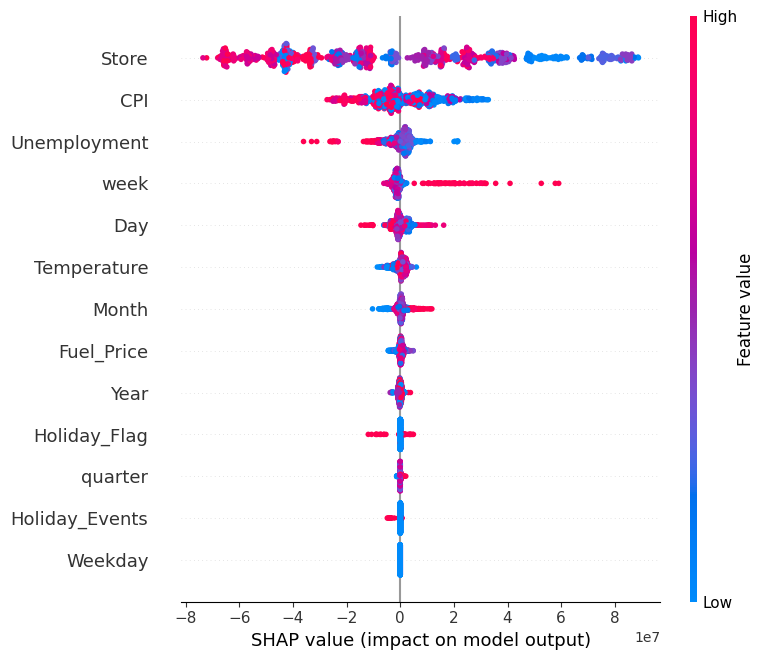

In [9]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
# Visualizar las características más importantes
shap.summary_plot(shap_values, X_test)

En el gráfico se muestran las características ordenadas de mayor a menor importancia. Se observa que las más relevantes para las predicciones del modelo son **Store** y **CPI**, lo que indica una fuerte dependencia del modelo en estas variables. Sin embargo, analizaremos los resultados de la eliminación recursiva de características (RFE) para obtener una perspectiva más detallada.

## RFE

**Veamos cuales son las 5 características más importantes.**

In [11]:
rfe = RFE(model, n_features_to_select=5)  # Seleccionar las 5 características más importantes
rfe = rfe.fit(X_train, Y_train)

# Mostrar las características seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Store', 'CPI', 'Unemployment', 'Holiday_Events', 'week'], dtype='object')


**Entrenemos el modelo con estas características y veamos si obtenemos el mismo rendimiento.**

In [12]:
# Filtrar las características seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model_selected = XGBRegressor(**params)
model_selected.fit(X_train_selected, Y_train)
y_pred_reduced2 = model_selected.predict(X_test_selected)
print("R2 Score con características reducidas:", r2_score(Y_test, y_pred_reduced2))

R2 Score con características reducidas: 0.9708532094955444


Veamos si esta puntuación se reduce si solo usamos tres características relevantes.

In [13]:
rfe = RFE(model, n_features_to_select=3)  
rfe = rfe.fit(X_train, Y_train)

# Mostrar las características seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Store', 'CPI', 'Unemployment'], dtype='object')


In [14]:
X_train_selected2 = X_train[selected_features]
X_test_selected2 = X_test[selected_features]
model_selected2 = XGBRegressor(**params)
model_selected2.fit(X_train_selected2, Y_train)

y_pred_reduced3 = model_selected2.predict(X_test_selected2)
print("R2 Score con características reducidas:", r2_score(Y_test, y_pred_reduced3))

R2 Score con características reducidas: 0.9318690299987793


Con solo tres características relevantes,, el modelo sigue teniendo muy buen R2;; esto quiere decir que podemos entrenar el modelo usando solo tres características importantes, que son :

- **Store**
- **CPI**
- **Unemployment**

Sin embargo, vamos a usar las cinco características más importantes.

# Entrenamiento y test del modelo con datos importantes

Vamos a seleccionar las cinco características más importantes y veamos cómo se comporta el modelo al hacer las predicciones.

In [16]:
datanorRed = datanor[['Weekly_Sales','Store', 'CPI', 'Unemployment', 'Holiday_Events', 'week']]
muestraRed = muestra[['Weekly_Sales','Store', 'CPI', 'Unemployment', 'Holiday_Events', 'week']]

independientes = datanorRed.drop(columns=['Weekly_Sales'],axis=1) 
objetivo = datanorRed['Weekly_Sales'] 

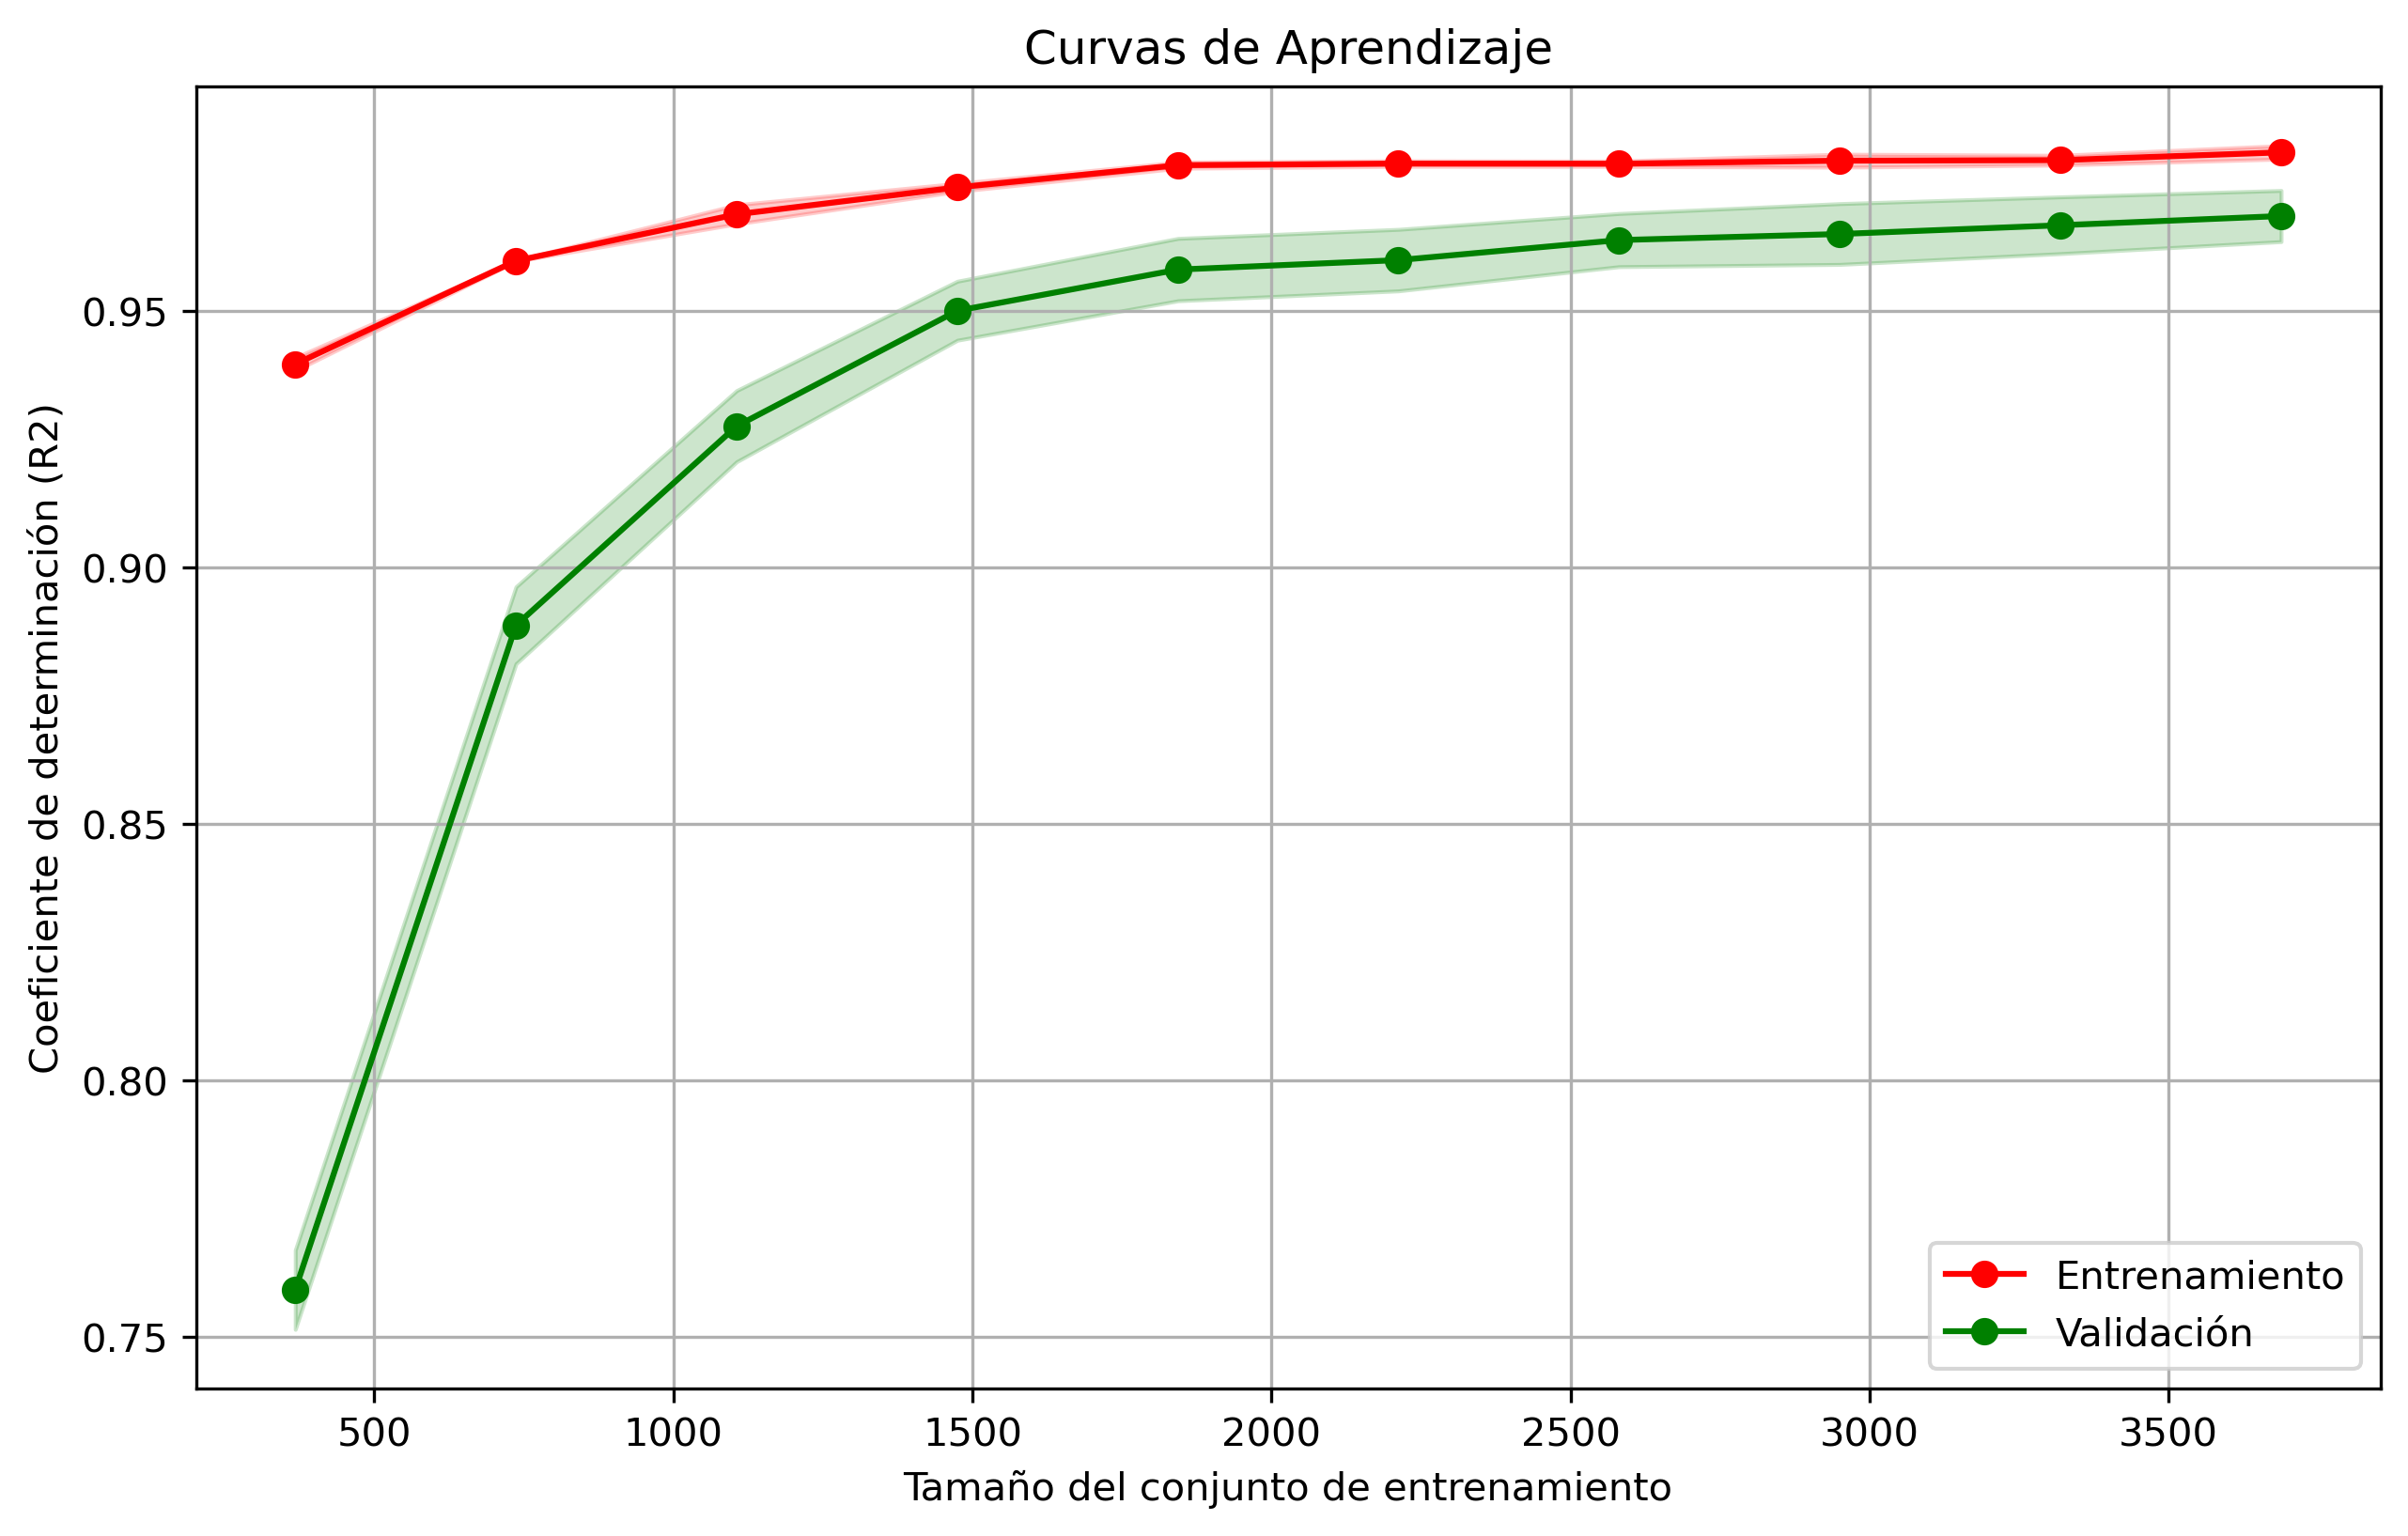

In [19]:
model_final = XGBRegressor(**params)

# Generar curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_final,            
    independientes,         
    objetivo,               
    cv=5,                   
    scoring='r2',           
    train_sizes=np.linspace(0.1, 1.0, 10),  # Tamaños de entrenamiento
    n_jobs=-1               
)

# Promedio y desviación estándar de los puntajes
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Gráfica de las curvas de aprendizaje
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.2)

# Etiquetas y leyenda
plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Coeficiente de determinación (R2)")
plt.legend(loc="best")
plt.grid()
plt.show()

El modelo no muestra signos de sobreajuste, ya que las curvas de aprendizaje son razonablemente cercanas y la curva de validación no se estabiliza en un valor significativamente inferior al de entrenamiento. A continuación, evaluaremos las predicciones utilizando una muestra que el modelo no ha visto previamente.

In [22]:
model_final = XGBRegressor(**params)
model_final.fit(independientes, objetivo)
prediciones = model_final.predict(muestraRed.drop(columns=['Weekly_Sales'],axis=1))
MAE = metrics.mean_absolute_error(muestraRed['Weekly_Sales'], prediciones)
MSE = metrics.mean_squared_error(muestraRed['Weekly_Sales'], prediciones)
RMSE = np.sqrt(MSE)
error_Observacion= np.absolute(muestraRed['Weekly_Sales'] - prediciones)
coeficiente_determinacion = metrics.r2_score(muestraRed['Weekly_Sales'], prediciones)
n = len(muestraRed['Weekly_Sales'])
k = len(params) 
# Calculando R2 ajustado
PorcentajeError = (RMSE*100)/(muestraRed['Weekly_Sales'].mean())
R2_ajustado = 1 - ((1 - coeficiente_determinacion) * (n - 1)) / (n - k - 1)
print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"Coeficiente de determinación (R2): {coeficiente_determinacion}")
print(f"R2 ajustado: {R2_ajustado}")
print(f"PorcentajeError: {PorcentajeError}")

MAE: 6467153.496964441
MSE: 118209741443745.47
RMSE: 10872430.337497935
Coeficiente de determinación (R2): 0.9645913243293762
R2 ajustado: 0.9643748520763681
PorcentajeError: 10.246827483625355


Umm...

El modelo tiene un buen R2 ajustado; sin embargo, el error es del 10.25%. ¿Este error pequeño?

¿El error lo podemos disminuir? Por el momento, veamos si se cumplen los supuestos de la regresión lineal.

# Cumplimiento de supuestos de la RL

Vamos a comprobar si el modelo cumple con los supuestos de la regresión lineal; esto incluye las siguientes pruebas:

- **Residual Plot**
- **Breusch-Pagan test**
- **Durbin-Watson test**
- **Q-Qplot**
- **Shapiro-Wilk test**
- **Factor de Inflación de la Varianza VIF**

## Residual Plot

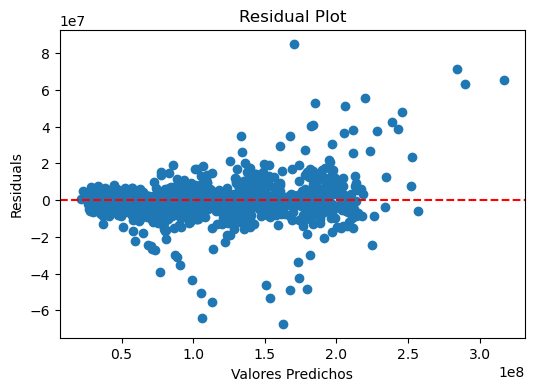

In [23]:
Y_val =muestraRed['Weekly_Sales']
residuals = Y_val - prediciones
# graficando residuales
plt.figure(figsize=(6, 4))
plt.scatter(prediciones, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Al parecer aún hay heterocedasticidad en los residuos, y observa algunos valores atípicos. Muy probablemente sea necesario aplicar una transformación a la variable objetivo. Sin embargo, verifiquemos esto con Breusch-Pagan test.

## Breusch-Pagan test

Hipótesis nula (H0): Los residuos son homocedásticos, es decir, tienen varianza constante.

Hipótesis alternativa (H1): Los residuos son heterocedásticos, es decir, su varianza cambia en función de las variables explicativas.

Si p-value > 0.05, no se puede rechazar la hipótesis nula.

Si p-value < 0.05, se puede rechazar la hipótesis nula.

In [27]:
# Añade la constante al conjunto de variables predictoras
X_with_constant = sm.add_constant(muestraRed.drop(columns=['Weekly_Sales'], axis=1))
bp_test = sms.het_breuschpagan(residuals, X_with_constant)
print('Estadístico de Breusch-Pagan:', bp_test[0])
print('p-valor:', bp_test[1])

Estadístico de Breusch-Pagan: 54.57138083145183
p-valor: 1.599154539263751e-10


Se rechaza la hipótesis nula y se afirma que existe heterocedasticidad en los residuos.

El resultado de la prueba de Breusch-Pagan sugiere que hay evidencia fuerte de heterocedasticidad en el modelo. Esto significa que la varianza de los residuos no es constante, lo que puede afectar la precisión de los estimadores y las inferencias estadísticas.

## Durbin-Watson test

Se usa para detectar autocorrelación.

Interpretación del valor:

- Valor cercano a 2: Indica poca o ninguna autocorrelación.
- Valor cercano a 0: Indica autocorrelación positiva (los errores tienden a seguir patrones).
- Valor cercano a 4: Indica autocorrelación negativa.

In [28]:
dw_test = durbin_watson(residuals)
print(f'Durbin-Watson test statistic: {dw_test}')

Durbin-Watson test statistic: 1.8740877748000602


Podemos ver que el valor es muy cercano a 2; esto indica que el modelo no presenta problemas de autocorrelación en los residuos. Esto indica que el modelo cumple con **la independencia de los errores**. ¡Esto es perfecto!

## Q-Qplot

Veamos si los residuos siguen una distribución normal.

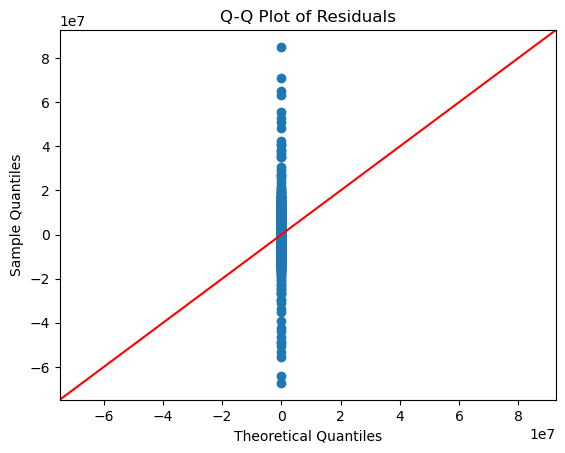

In [29]:
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

El gráfico indica que los residuales no siguen una distribución normal, lo cual es un supuesto importante en muchos modelos lineales y en la evaluación de la significancia estadística.

## Shapiro-Wilk test

Comprobemos lo visto en el gráfico Q-Qplot.

- Hipótesis nula (H0): Los datos siguen una distribución normal.
- Hipótesis alternativa (H1): Los datos no siguen una distribución normal.

p-valor > 0.05, no se rechaza la hipótesis nula.

In [30]:
shapiro_test = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value:', shapiro_test[1])

Shapiro-Wilk test p-value: 4.173412928351677e-36


Se rechaza la hipótesis nula, lo que afirma que los residuos no siguen una distribución normal.

## VIF

Valores altos de VIF (generalmente mayores a 10) indican que una variable está altamente correlacionada con las demás, lo que puede causar inestabilidad en las estimaciones de los coeficientes del modelo.

In [31]:
vif_data = pd.DataFrame()
X = muestraRed.drop(columns=['Weekly_Sales'], axis=1) 
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filtrar e imprimir las variables con VIF > 5
high_vif = vif_data[vif_data["VIF"] > 5]

if not high_vif.empty:
    print("Variables con VIF mayor a 5:")
    print(high_vif)
    # Eliminar variables con VIF muy alto
    X = X.drop(columns=high_vif["feature"])
else:
    print("No hay variables con VIF mayor a 5.")

No hay variables con VIF mayor a 5.


Se cumple la no multicolinealidad perfecta.

# Resultados y conclusiones

A modo de resumen tenemos los siguientes resultados:

- Las características más importantes para las predicciones del modelo son: Store, CPI, Unemployment, Holiday_Events y week, alcanzando un coeficiente de determinación (R²) del 97%. Sin embargo, el modelo puede simplificarse utilizando solo tres características: Store, CPI y Unemployment, aunque esto reduciría el R² al 93%.
- Las pruebas estadísticas indican que el modelo no cumple con la homocedasticidad de los residuos ni con la normalidad de los mismos. Sin embargo, dado que el tamaño de la muestra es considerable (1153 datos), el Teorema del Límite Central sugiere que esto podría no ser un problema significativo, especialmente si el enfoque principal es la predicción.
- El modelo cumple con los supuestos de independencia de los errores y ausencia de multicolinealidad perfecta. Esto implica que no hay autocorrelación en los residuos y que las variables predictoras no están altamente correlacionadas, lo cual es positivo para la estabilidad del modelo.
- Si el objetivo del modelo es realizar predicciones y no inferencia estadística estricta, las violaciones de los supuestos de normalidad y homocedasticidad son menos relevantes. Por otro lado, si se busca realizar inferencias, es necesario abordar estas violaciones para garantizar la validez de las conclusiones.


**A modo de conclusión se tiene lo siguiente:**

- El modelo es adecuado y útil para predicciones, pero si el objetivo incluye inferencias estadísticas, será fundamental corregir los problemas relacionados con la homocedasticidad y la normalidad de los residuos.